In [1]:
import os
import torch

import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
# plot
import matplotlib.pyplot as plt
import seaborn as sns
# daa
from data import pre_processing
from datetime import datetime
from datetime import timedelta
from torch_geometric.data import Data
from sklearn.model_selection import KFold
# config
# set seed
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')
#plt.style.use('seaborn-darkgrid')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-whitegrid')

# Define Tresh

## Sobe e Desce 01/03/2024

In [2]:
tts = pd.read_parquet('/mnt/data/sobe_desce/03_2024/2024-03-01/output/trips_time-series_01-03-2024_01-03-2024.parquet')
tts.head()

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,saida,fill,tempo_parada,duracao,tempo_total,tempo_parada_acum,duracao_acum,distancia,dis_acum,vm,vm_acum,type
0,123101_57892,123101,57892,I,57892_I,1,44782944,-12.942813,-38.438602,0.000,0.000,inicial,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:30:58,2024-03-01 05:30:58,False,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,bus
1,123101_57892,123101,57892,I,57892_I,2,44784618,-12.939712,-38.438862,0.449,0.449,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:32:18,2024-03-01 05:32:25,False,7.0,80.0,87.0,7.0,80.0,0.345999,0.000000,15.569937,0.000000,bus
2,123101_57892,123101,57892,I,57892_I,3,44784340,-12.938302,-38.439884,0.126,0.575,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:32:46,2024-03-01 05:33:22,False,36.0,21.0,57.0,43.0,101.0,0.191938,0.345999,32.903659,12.332624,bus
3,123101_57892,123101,57892,I,57892_I,4,44782337,-12.935150,-38.440578,0.523,1.098,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:35:31,2024-03-01 05:36:03,False,32.0,129.0,161.0,75.0,230.0,0.358460,0.537937,10.003548,8.419877,bus
4,123101_57892,123101,57892,I,57892_I,5,44784470,-12.937017,-38.437576,0.417,1.515,intermediario,21224,1.0,21224_123101_1,2024-03-01 05:30:58,2024-03-01 06:51:28,ottrans,2024-03-01 05:36:50,2024-03-01 05:37:07,False,17.0,47.0,64.0,92.0,277.0,0.385962,0.896397,29.563075,11.649926,bus


In [3]:
def create_edge_graph(dataf):
    # create graph
    dfs = []
    dataf['src'] = dataf['stop_id']
    for trip_id, df_trip_id in tqdm(dataf.groupby('trip_id')):

        df_trip_id['dst']     = df_trip_id['src'].shift(-1)
        df_trip_id['vm_edge'] = df_trip_id['vm'].shift(-1)
        df_trip_id['vm_acum_edge'] = df_trip_id['vm_acum'].shift(-1)
        df_trip_id['distance'] = df_trip_id['distancia'].shift(-1)

        df_tpi_fix = df_trip_id.dropna()

        dfs.append(df_tpi_fix[['src', 'dst', 'vm_edge', 'vm_acum_edge', 'distance']])

    df_raw_graph = pd.concat(dfs, ignore_index=True)
    df_raw_graph_din = df_raw_graph.pivot_table(index=['src', 'dst'], 
                                                values=['vm_edge', 'vm_acum_edge', 'distance'],
                                                aggfunc='mean',
                                               ).reset_index()
    return df_raw_graph, df_raw_graph_din

In [4]:
# pre processamento para remover outliears
tts['vm'][tts['vm'] < 0] = pd.NA
tts['vm'][tts['vm'] > 80] = pd.NA
tts['vm'] = tts['vm'].fillna(method='ffill')

In [5]:
tts['vm_acum'][tts['vm_acum'] < 0] = pd.NA
tts['vm_acum'][tts['vm_acum'] > 80] = pd.NA
tts['vm_acum'] = tts['vm_acum'].fillna(method='ffill')

In [6]:
tts_all, tts_vm = create_edge_graph(tts)
tts_vm.head()

100% 22928/22928 [01:16<00:00, 301.20it/s]


,src,dst,distance,vm_acum_edge,vm_edge
0,100009577,345936831,0.267731,8.981441,29.859325
1,100722777,100722778,0.300592,19.768019,15.494709
2,100722777,44782645,0.573758,19.509918,10.865240
3,100722777,45833440,0.304342,18.820540,16.153585
4,100722777,66771046,0.596821,14.022194,14.545003


In [7]:
tts_all.pivot_table(index=['src', 'dst'], 
                    values=['vm_edge', 'vm_acum_edge', 'distance'],
                    aggfunc='median').reset_index()

,src,dst,distance,vm_acum_edge,vm_edge
0,100009577,345936831,0.267731,9.106872,30.119789
1,100722777,100722778,0.300592,19.249543,15.459010
2,100722777,44782645,0.573758,19.313007,10.702213
3,100722777,45833440,0.304342,18.948736,14.137782
4,100722777,66771046,0.596821,13.630533,14.640957
...,...,...,...,...,...
4467,99834780,50059435,0.231816,17.844128,24.545190
4468,99834781,99834780,0.160283,17.959359,22.193043
4469,99834782,99834783,0.182229,14.938370,26.240919
4470,99834783,46021757,0.340286,10.958974,14.162681


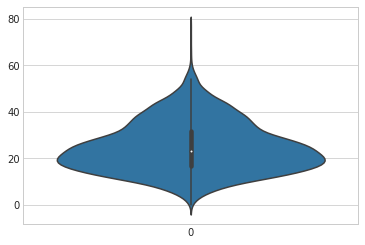

In [8]:
sns.violinplot(tts_vm.vm_edge.values)
plt.show()

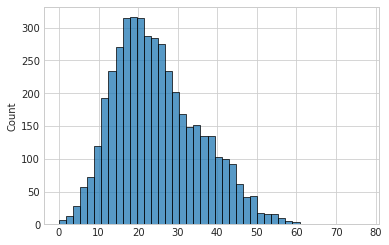

In [9]:
#sns.violinplot(tts_vm.vm_edge.values)
#plt.show()

sns.histplot(tts_vm.vm_edge.values)
plt.show()

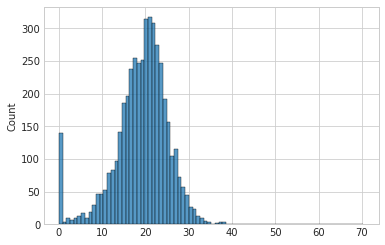

In [10]:
sns.histplot(tts_vm.vm_acum_edge.values)
plt.show()

In [11]:
# median tresh
tts_vm = tts_vm.rename({'vm_edge': 'tresh'}, axis=1)
tts_vm.head()

,src,dst,distance,vm_acum_edge,tresh
0,100009577,345936831,0.267731,8.981441,29.859325
1,100722777,100722778,0.300592,19.768019,15.494709
2,100722777,44782645,0.573758,19.509918,10.865240
3,100722777,45833440,0.304342,18.820540,16.153585
4,100722777,66771046,0.596821,14.022194,14.545003


In [12]:
# quartils method
tts_vm['q1'] = None
tts_vm['q2'] = None
tts_vm['q3'] = None

In [13]:
# for i in tqdm(range(tts_vm.shape[0])):
#     stop_id = tts_vm.stop_id.iloc[i]
#     # sb_tresh_loader['tresh'].iloc[i] =  sb.query(f" ponto == '{stop_id}'  ")['carregamento_fit'].mean()
#     qs = tts.query(f" src == '{stop_id}'  ")['vm'].quantile([0.25, 0.5, 0.75]).values
#     sb_tresh_loader['q1'].iloc[i] = qs[0]
#     sb_tresh_loader['q2'].iloc[i] = qs[1]
#     sb_tresh_loader['q3'].iloc[i] = qs[2]

# Define data to train and test - 08/03/2024

In [14]:
faixa = 19

### Node features (sobe e desce)

In [15]:
# read sobe e desce from another day
sb_train = pd.read_csv('/mnt/data/sobe_desce/03_2024/2024-03-08/output/sobe_desce_08-03-2024_esp.csv')
sb_train['hora_ponto'] = pd.to_datetime(sb_train['hora_ponto'], format='%Y-%m-%d %H:%M:%S')
sb_train = sb_train.rename({'ponto': 'stop_id'}, axis=1)
sb_train = sb_train.astype({'stop_id': 'str'})
sb_train.head()

,index,linha,cod_ate,sentido,ordem,stop_id,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,sobe,desce,lag_carregamento,saldo,carregamento,sobe_fit,lag_carregamento_fit,desce_fit,saldo_fit,carregamento_fit,percent_desce,percent_sobe_esp,sobe_especie,sobe_total_especie,lag_carregamento_especie,desce_total_especie,saldo_especie,carregamento_especie,percent_desce_fit
0,11353,1137,33228,I,1,45833577,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:10:32,11.0,0.0,0,0,11,11.0,0.0,0.0,0.0,11.0,0.0,1.270208,1.765589,12.765589,0.000000,0.0,0.000000,12.765589,0.0
1,11354,1137,33228,I,2,45833578,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:10:59,9.0,0.0,11,11,20,9.0,11.0,0.0,11.0,20.0,0.0,1.039261,1.444573,10.444573,12.765589,0.0,12.765589,23.210162,0.0
2,11355,1137,33228,I,3,45832840,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:13:13,1.0,0.0,20,20,21,1.0,20.0,0.0,20.0,21.0,0.0,0.115473,0.160508,1.160508,23.210162,0.0,23.210162,24.370670,0.0
3,11356,1137,33228,I,4,45833571,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:14:04,3.0,0.0,21,21,24,3.0,21.0,0.0,21.0,24.0,0.0,0.346420,0.481524,3.481524,24.370670,0.0,24.370670,27.852194,0.0
4,11357,1137,33228,I,5,45832819,20937,1,20937_1137_1,2024-03-08 05:10:32,2024-03-08 05:37:51,ottrans,2024-03-08 05:14:42,5.0,0.0,24,24,29,5.0,24.0,0.0,24.0,29.0,0.0,0.577367,0.802540,5.802540,27.852194,0.0,27.852194,33.654734,0.0


In [16]:
# criar o atributo da faixa
sb_train['faixa'] = sb_train.hora_ponto.dt.hour
sb_faixa_selecionada = sb_train.query(f" faixa == {faixa} ")
sb_faixa_selecionada.shape, sb_train.shape

((46613, 33), (735127, 33))

In [17]:
# loader
nf_loader = sb_faixa_selecionada.pivot_table(index=['stop_id'], 
                                    values='carregamento_fit', 
                                    aggfunc='mean').reset_index()
# sobe
nf_sobe = sb_faixa_selecionada.pivot_table(index='stop_id', 
                        values='sobe_fit', 
                        aggfunc='sum').reset_index()
# desce
nf_desce = sb_faixa_selecionada.pivot_table(index='stop_id', 
                        values='desce_fit', 
                        aggfunc='sum').reset_index()
# veiculos
nf_veic = sb_faixa_selecionada.pivot_table(index='stop_id', 
                        values='veiculo', 
                        aggfunc=pd.Series.nunique).reset_index()
# linhas
nf_lines = sb_faixa_selecionada.pivot_table(index='stop_id', 
                        values='linha', 
                        aggfunc=pd.Series.nunique).reset_index()
# viagens
nf_trips = sb_faixa_selecionada.pivot_table(index='stop_id', 
                        values='trip_id', 
                        aggfunc=pd.Series.nunique).reset_index()

In [18]:
# Merge the DataFrames on the 'stop_id' column
merged_df = nf_sobe.merge(nf_desce, on='stop_id', suffixes=('_sobe', '_desce'))
merged_df = merged_df.merge(nf_veic, on='stop_id')
merged_df = merged_df.merge(nf_lines, on='stop_id')
merged_df = merged_df.merge(nf_trips, on='stop_id')
merged_df = merged_df.merge(nf_loader, on='stop_id')

# Rename columns for clarity (optional)
merged_df.columns = ['stop_id', 'sobe_fit', 'desce_fit', 'veiculo', 'linha', 'trip_id', 'carregamento_fit']

merged_df.head()

,stop_id,sobe_fit,desce_fit,veiculo,linha,trip_id,carregamento_fit
0,100009577,0.0,0.000000,4,2,4,0.000000
1,100722777,58.0,59.791885,20,8,20,26.452158
2,100722778,1.0,23.974681,28,8,28,31.778628
3,101214305,2.0,42.513896,4,1,4,30.122097
4,101269104,201.0,72.946333,81,22,81,28.700818


###  Edge Features (trip time series)

In [19]:
tts = pd.read_parquet(f'/mnt/data/sobe_desce/03_2024/2024-03-08/output/trips_time-series_08-03-2024_08-03-2024.parquet')
tts.head()

,linha_atend,linha,cod_ate,sentido,shape,ordem,stop_id,lat,lon,distancias,acumulado,posicao,veiculo,trip,trip_id,inicio_viagem,fim_viagem,set,hora_ponto,saida,fill,tempo_parada,duracao,tempo_total,tempo_parada_acum,duracao_acum,distancia,dis_acum,vm,vm_acum,type
0,1374_30966,1374,30966,I,30966_I,1,110438500,-12.942272,-38.421867,0.000,0.000,inicial,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:25:17,2024-03-08 06:26:05,False,48.0,0.0,48.0,48.0,0.0,0.000000,0.000000,0.000000,0.000000,bus
1,1374_30966,1374,30966,I,30966_I,2,110952763,-12.940207,-38.427055,0.922,0.922,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:27:01,2024-03-08 06:27:05,False,4.0,56.0,60.0,52.0,56.0,0.607295,0.000000,39.040412,0.000000,bus
2,1374_30966,1374,30966,I,30966_I,3,110952766,-12.937143,-38.425938,0.391,1.313,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:28:03,2024-03-08 06:28:10,False,7.0,58.0,65.0,59.0,114.0,0.361609,0.607295,22.444727,19.177746,bus
3,1374_30966,1374,30966,I,30966_I,4,45833801,-12.934586,-38.425152,0.386,1.699,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:29:41,2024-03-08 06:30:23,False,42.0,91.0,133.0,101.0,205.0,0.296886,0.968905,11.744958,17.014913,bus
4,1374_30966,1374,30966,I,30966_I,5,45833482,-12.933431,-38.422264,0.457,2.156,intermediario,20771,1.0,20771_1374_1,2024-03-08 06:25:17,2024-03-08 06:44:25,ottrans,2024-03-08 06:31:21,2024-03-08 06:31:32,False,11.0,58.0,69.0,112.0,263.0,0.338278,1.265791,20.996542,17.326420,bus


In [20]:
# add faixa
tts['faixa'] = tts.hora_ponto.dt.hour
tts_faixa = tts.query(f" faixa == {faixa} ")
# pre processing 
# pre processamento para remover outliears
tts_faixa['vm'][tts_faixa['vm'] < 0] = pd.NA
tts_faixa['vm'][tts_faixa['vm'] > 80] = pd.NA
tts_faixa['vm'] = tts_faixa['vm'].fillna(method='ffill')

In [21]:
_, edge_featues = create_edge_graph(tts_faixa)
edge_featues.head()

100% 2523/2523 [00:08<00:00, 305.28it/s]


,src,dst,distance,vm_acum_edge,vm_edge
0,100009577,345936831,0.267731,9.466312,30.674554
1,100722777,100722778,0.300592,12.648182,2.374013
2,100722777,44782645,0.573758,15.656182,6.186022
3,100722777,45833440,0.304342,15.345674,7.504332
4,100722777,66771046,0.596821,10.982229,5.865519


In [22]:
#edge_featues = edge_featues.rename({'vm_edge': 'tresh'}, axis=1)

In [23]:
stop_id_stop_time = tts_faixa.pivot_table(index='stop_id', 
                                 values='tempo_parada', 
                                 aggfunc='mean').reset_index()

In [24]:
def select_target_tresh(stop_id_src, 
                         stop_id_dst,
                         ocupation, 
                         dataf):
    
    df_stop = dataf.query(f" src == '{stop_id_src}' and dst == '{stop_id_dst}' ")
    
    if df_stop.shape[0] > 0:
        tresh = df_stop['tresh'].values[0]
        if ocupation <= tresh:
            return 'baixo'
        elif ocupation > tresh:
            return 'alta'
    
    return 'sem_classe'

In [25]:
edge_featues['target_loader'] = None
for idx in tqdm(range(edge_featues.shape[0])):
    s, d, v = edge_featues[['src', 'dst', 'vm_edge']].iloc[idx]
    edge_featues['target_loader'].iloc[idx] = select_target_tresh(s, d, v, tts_vm)    

100% 4208/4208 [00:10<00:00, 409.94it/s]


In [26]:
edge_featues['target_loader'].value_counts(dropna=False)

baixo         2155
alta          2050
sem_classe       3
Name: target_loader, dtype: int64

In [27]:
'''
alta          2786
baixo         1408
sem_classe       2
'''

'\nalta          2786\nbaixo         1408\nsem_classe       2\n'

In [28]:
# remove cases wihout class
df_edge_features = edge_featues.query(" target_loader not in ['sem_classe'] ")
df_edge_features.head()

,src,dst,distance,vm_acum_edge,vm_edge,target_loader
0,100009577,345936831,0.267731,9.466312,30.674554,alta
1,100722777,100722778,0.300592,12.648182,2.374013,baixo
2,100722777,44782645,0.573758,15.656182,6.186022,baixo
3,100722777,45833440,0.304342,15.345674,7.504332,baixo
4,100722777,66771046,0.596821,10.982229,5.865519,baixo


## Pre-processamento

In [29]:
df_node_features = merged_df.copy()
df_node_features.head()

,stop_id,sobe_fit,desce_fit,veiculo,linha,trip_id,carregamento_fit
0,100009577,0.0,0.000000,4,2,4,0.000000
1,100722777,58.0,59.791885,20,8,20,26.452158
2,100722778,1.0,23.974681,28,8,28,31.778628
3,101214305,2.0,42.513896,4,1,4,30.122097
4,101269104,201.0,72.946333,81,22,81,28.700818


In [30]:
df_node_features.shape

(2812, 7)

In [31]:
df_node_features_add = df_node_features.merge(stop_id_stop_time, on=['stop_id'], how='left')
df_node_features_add.shape

(2812, 8)

In [32]:
df_node_features = df_node_features_add.copy()

In [33]:
# columns to select as features
features_cols = ['carregamento_fit', 'tempo_parada', 'sobe_fit', 'linha', 'sobe_fit', 'trip_id', 'veiculo']
#features_cols = ['tempo_parada', 'linha', 'sobe_fit','veiculo']

#df_node_features = df_node_features.drop(['target_loader'], axis=1)
df_node_features = df_node_features.rename({'stop_id': 'leg_pos'}, axis=1)
df_node_features = df_node_features.astype({'leg_pos': str})

In [34]:
df_edges_features = df_edge_features.rename({'src': 'pos1', 'dst': 'pos2', 'distance': 'weight'}, axis=1)
df_edges_features = df_edges_features.astype({'pos1': str, 'pos2': str})
df_edges_features.head()

,pos1,pos2,weight,vm_acum_edge,vm_edge,target_loader
0,100009577,345936831,0.267731,9.466312,30.674554,alta
1,100722777,100722778,0.300592,12.648182,2.374013,baixo
2,100722777,44782645,0.573758,15.656182,6.186022,baixo
3,100722777,45833440,0.304342,15.345674,7.504332,baixo
4,100722777,66771046,0.596821,10.982229,5.865519,baixo


In [35]:
df_node_features.head()

,leg_pos,sobe_fit,desce_fit,veiculo,linha,trip_id,carregamento_fit,tempo_parada
0,100009577,0.0,0.000000,4,2,4,0.000000,18.000000
1,100722777,58.0,59.791885,20,8,20,26.452158,110.250000
2,100722778,1.0,23.974681,28,8,28,31.778628,88.392857
3,101214305,2.0,42.513896,4,1,4,30.122097,48.500000
4,101269104,201.0,72.946333,81,22,81,28.700818,25.950617


In [36]:
x, edge_labels, edge_index, edge_weights, pos =  pre_processing(df_edges_features, 
                                                          df_node_features, 
                                                          features_cols,
                                                          col_target='target_loader', 
                                                          col_edges=['weight'])

100% 2812/2812 [00:10<00:00, 276.83it/s]


In [37]:
edge_labels_ohe = torch.nn.functional.one_hot(edge_labels).float()
edge_labels_ohe.shape

torch.Size([4205, 2])

## Create Kfold and save data

In [38]:
edge_index_np = edge_index.numpy()  
edge_labels_np = edge_labels_ohe.numpy()  
edge_weights_np = edge_weights.numpy() 
edge_index_np.shape

(4205, 2)

In [39]:
edge_weights_np.shape

(4205, 1)

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, test_idx) in enumerate(kf.split(edge_index_np)):
    fold_idx = fold + 1
    print(f"Fold {fold_idx}")
    

    # Split the data
    X_train, X_test = edge_index_np[train_idx], edge_index_np[test_idx]
    y_train, y_test = edge_labels_np[train_idx], edge_labels_np[test_idx]
    w_train, w_test = edge_weights_np[train_idx], edge_weights_np[test_idx]

    # Convert back to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long).t()  # Transpose back to shape [2, num_train_edges]
    X_test = torch.tensor(X_test, dtype=torch.long).t()  # Transpose back to shape [2, num_test_edges]

    y_train = torch.tensor(y_train, dtype=torch.long)  # Shape: [num_train_edges]
    y_test = torch.tensor(y_test, dtype=torch.long)  # Shape: [num_test_edges]

    w_train = torch.tensor(w_train, dtype=torch.float)  # Shape: [num_train_edges]
    w_test = torch.tensor(w_test, dtype=torch.float)  # Shape: [num_test_edges]

    # Create Data objects
    train_data = Data(
        x=x,
        edge_index=X_train,
        edge_label=y_train.float(),
        edge_attr=w_train
    )

    test_data = Data(
        x=x,
        edge_index=X_test,
        edge_label=y_test.float(),
        edge_attr=w_test
    )
    
    # save
    torch.save(train_data, f'../../data/graph_designer/train_test_edge_classification_days/train_data_{fold_idx}.pt')
    torch.save(test_data, f'../../data/graph_designer/train_test_edge_classification_days/test_data_{fold_idx}.pt')
    
    # Print out the fold results (or store them for later analysis)
    print(f"Train data: {train_data}")
    print(f"Test data: {test_data}")
    print()

Fold 1
Train data: Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])
Test data: Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

Fold 2
Train data: Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])
Test data: Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

Fold 3
Train data: Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])
Test data: Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

Fold 4
Train data: Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])
Test data: Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

Fold 5
Train data: Data(x=[2812, 7], edge_index=[2, 3364], edge_attr=[3364, 1], edge_label=[3364, 2])
Test data: Data(x=[2812, 7], edge_index=[2, 841], edge_attr=[841, 1], edge_label=[841, 2])

